<a href="https://colab.research.google.com/github/esl-epfl/cross-domain-saliency-maps/blob/main/examples/seizure_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this example we interpret the outputs of a deep model processing [electroencephalography](https://en.wikipedia.org/wiki/Electroencephalography) (EEG) signals, classifying them into seizure or non-seizure inputs.

We decompose the electrical signals into the different sources/mechanisms (e.g. epileptic activity, muscle interference, noise, etc.) and then isolate the ones that the model considers important in detecting seizures. To calculate the importance of each these components we use the [Cross-domain Saliency Maps library](https://github.com/esl-epfl/cross-domain-saliency-maps). We will isolate the components using [Independent Component Analysis](https://en.wikipedia.org/wiki/Independent_component_analysis) and [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform).

# Download libraries and data

First, let's download the libraries and data we will need:
- **Cross-domain saliency maps** for generating saliency maps expressed custom domains. We will use it to isolate Independent Components and Frequencies which the epilepsy-predicting model considers important in detecting seizures from electroencephalography (EEG) signals.
- **Zhu transformer** is a pre-trained model detecting seizures from EEG inputs.
- **Example EEG input** taken from the [Physionet Siena Scalp EEG Database
v1.0.0](https://physionet.org/content/siena-scalp-eeg/1.0.0/) dataset.

In [ ]:
!pip install git+https://github.com/esl-epfl/cross-domain-saliency-maps@main
!pip install git+https://github.com/esl-epfl/zhu_2023.git@main#subdirectory=zhu
!pip install mne

In [ ]:
!git clone https://github.com/esl-epfl/cross-domain-saliency-maps-paper.git

In [ ]:
from zhu.utils import load_model, load_thresh, get_dataloader, predict, get_predict_mask
import torch
from epilepsy2bids.eeg import Eeg
import numpy as np
from tqdm import tqdm

from cross_domain_saliency_maps.torch_ig.cross_domain_integrated_gradients import TimeIG
from cross_domain_saliency_maps.torch_ig.cross_domain_integrated_gradients import ICAIG
from cross_domain_saliency_maps.torch_ig.domain_transforms import ICADomain
from sklearn.decomposition import FastICA

import matplotlib.pyplot as plt

# Load model and data

In [ ]:
edf_root_folder = './cross-domain-saliency-maps-paper/eeg_zhu_transformer/data/eeg/'
edf_file = 'sub-00_ses-01_task-szMonitoring_run-02_eeg.edf'

eeg = Eeg.loadEdfAutoDetectMontage(edfFile = edf_root_folder + edf_file)

device = "cuda" if torch.cuda.is_available() else "cpu"

window_size_sec = 25
fs = eeg.fs
channels = [ch.split('-')[0] for ch in eeg.channels]

overlap_ratio = 1-1/window_size_sec
overlap_sec = window_size_sec * overlap_ratio

In [ ]:
model = load_model(window_size_sec, fs, device)
model.to(device)
model.eval()
prediction_threshold = load_thresh()

recording_duration = int(eeg.data.shape[1] / eeg.fs)

dataloader = get_dataloader(eeg.data, window_size_sec, fs)

# Detect seizures

Before interpreting any predictions let's find the samples which the model identifies as seizures. In the rest of this example we focus on the first sample that is detected as a seizure sample.

In [ ]:
preds = []
with torch.no_grad():
    for i, data in tqdm(enumerate(dataloader)):
        data = data.float().to(device)
        outputs = model(data)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        predicted = probs[:, 1] > prediction_threshold
        preds += predicted.cpu().detach().numpy().tolist()
preds = np.array(preds)

index_of_interest = np.argwhere(preds == 1).flatten()[0] + 1
data_of_interest = dataloader.dataset[index_of_interest]

# Isolate the very first sample identified as seizure.
X = data_of_interest.numpy()

Let's see what the signal looks like.

In [ ]:
def plot_multichannel_signals(x, channels, window_size_sec,
                              figsize = None,
                              n_channels = 19, offset = 125,
                              scale = 30.0):

  n_timepoints = x.shape[1]
  time = np.linspace(0, window_size_sec, n_timepoints)

  fig, ax = plt.subplots(figsize = figsize)

  for i in range(n_channels):
    ax.plot(time, scale * x[i, ...] + i * offset,
                 color='black', linewidth = 0.25,
                 alpha = 0.85)
    ax.set_xlim([time[0], time[-1]])
    ax.spines[['top', 'right']].set_visible(False)

  ax.set_yticks(list(range(1, 19 * offset, offset)), channels)
  ax.set_xlabel('Time (seconds)')

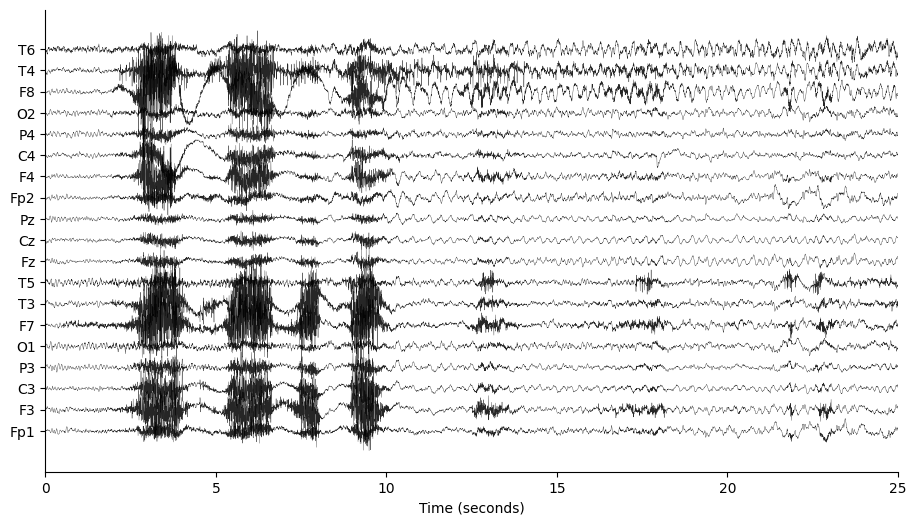

In [ ]:
plot_multichannel_signals(X, channels, window_size_sec, scale = 1.0, figsize = (11, 6))

The input signal consists of 19 channels and has a 25 second duration. There are seizure-related oscillations, synchronised between channels starting around 10-15 seconds. In the 3-10 second region there is heavy interference.

# Cross-domain Saliency Maps

**Saliency maps** are assigning a value of importance to each points in the model's inputs. A large value indicates that the corresponding point contributes significanlty to the output, while a small value hints to a small contribution.

The **Integrated Gradients** (IG) method is a saliency map method for deep learning models. It takes three inputs:
1. The model (```model```) the behaviour of which we want to investigate.
1. The input sample (```x```) is the input we want to interpret.
2. The baseline sample (```x_baseline```) is the signal that bears no information at all. For example, in images a completely black image can be considered the baseline.

Given these two inputs and the model, the IG then distributes the difference ```model(x) - model(x_baseline)``` among the input points ($x_i$). For example, the EEG signals are expressed in time: each input point $x_i$ is the value of electrical activity at a specific time instant $t_i$. The IG estimates how important each individual $x_i$ is for the model's seizure output.

The **Cross-domain Integrated Gradients** (Cross-domain IG) method generalises the IG, enabling attributions in other domains apart from the original input one. Instead of an importance value per time point, it estimates an importance per ***component***, allowing semantically meaningful saliency maps.

In addition to the three inputs required by the original IG, Cross-domain IG also requires a transform, which translates the original raw inputs into the *components*. For example the Fourier Transform can be used to translate time point importance into frequency-bin importance.  

Below, we generate saliency maps in the following domains:
1. **Time-domain**. This is the original IG saliency maps.
2. **ICA-domain**. We transform the original inputs into independent components, isolating seizure, interference and noise activities. The saliency map then highlights which of these *components* affected the model's output. A **trustworthy** inference should highlight the seizure activity only.
3. **Frequency-ICA-domain**. We create a custom composite transform to invstigate which frequency waves (e.g. alpha, beta) of each component mostly affect the output.

## Time-domain saliency maps

In [ ]:
class AddZeroWrapper(torch.nn.Module):
    def __init__(self, model):
        super(AddZeroWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        x = torch.cat([x, torch.zeros_like(x)], dim = 0)
        return self.model(x)[:1, ...]

In [ ]:
n_ig_iterations = 300

x = X[None, ...]
x_baseline = np.zeros_like(x)

model_wrapped = AddZeroWrapper(model)

In [ ]:
timeIG = TimeIG(model_wrapped, n_ig_iterations, output_channel = 1, device = device)
ig_time = timeIG.run(x, x_baseline).cpu().numpy()[0]

100%|██████████| 300/300 [00:05<00:00, 55.60it/s]


Text(0, 0.5, 'Per-channel Time-domain IG')

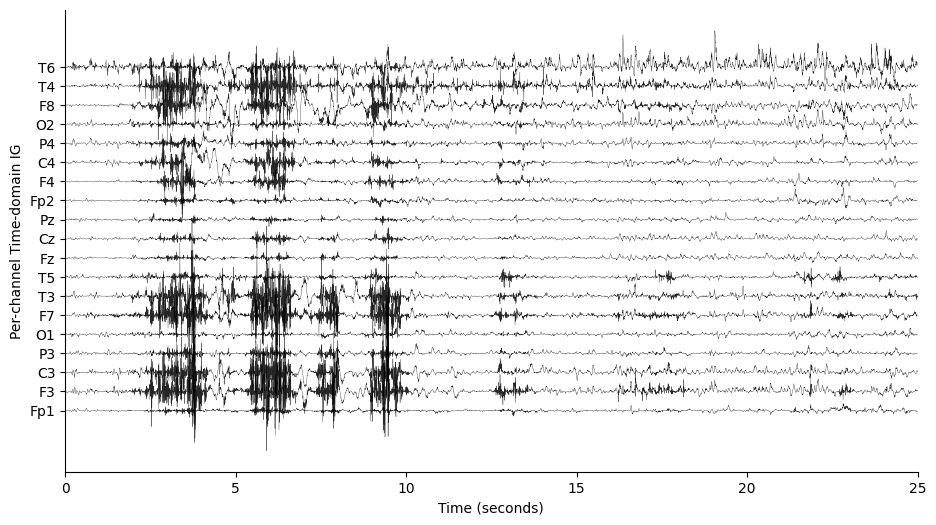

In [ ]:
plot_multichannel_signals(ig_time, channels, window_size_sec, scale = 1e5, figsize = (11, 6))
plt.ylabel('Per-channel Time-domain IG')

In each channel, the value at a time point, $t$, e.g. 10 seconds, represents the importance of the input signal at $t$. \
Positive values *push* the model towards a seizure inference. Equivalently, negative values *push* the output towards non-seizure.

**Saliency map interpretation.** IG has highlighted individual time points with larger values appearing around 5-10 seconds where an interference is located. The IG values are alternating fast between positive and negative ones.

However, overall it is not clear if the model has indeed detected the correct component, or it focuses on **confounding** information.

Seizure-related information is found in oscillating synchronised components. Time-domain IG does not capture that level of information.

## ICA-domain saliency maps

Independent Component Analysis is used in EEG analysis to isolate statistically independent signals, e.g. epileptic activity, muscle artifacts, noise, etc. In its output it provides 19 signals, as many as the input channels, each of which corresponds to an independent activity.

This enables us to investigate the importance of each activity as a whole, instead of each time point.

Before we continue with the ICA-IG, we first need to isolate the components. In this example we use ```sklearn.decomposition.FastICA``` but any compatible ICA object can also be used here.

In [ ]:
fastICA = FastICA(max_iter = 200, tol = 1e-9, random_state = 0)
X_ica = fastICA.fit_transform(X.T)

print("Run ", fastICA.n_iter_, " iterations.")

Run  200  iterations.


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Once our FastICA model is trained on the input data, we can perform ICA-IG.

In [ ]:
icaIG = ICAIG(model_wrapped, fastICA, n_ig_iterations, output_channel = 1, device = device)
ig_ica = icaIG.run(x, x_baseline).cpu().numpy()

100%|██████████| 300/300 [00:04<00:00, 60.75it/s]


In [ ]:
def plot_multichannel_with_importance(x, importance_scores, channels,
                                      window_size_sec, figsize,
                                      n_channels = 19, offset = 125,
                                      scale = 30.0):
  n_timepoints = x.shape[1]
  time = np.linspace(0, window_size_sec, n_timepoints)

  sorted_channel_indices = np.argsort(importance_scores)

  fig, axes = plt.subplots(figsize = figsize, nrows=1, ncols=2,
                         gridspec_kw={'width_ratios': [6, 1]}, sharey=True,
                         dpi=96.0)
  for i in range(n_channels):
      axes[0].plot(time, scale * x[sorted_channel_indices[i], ...] + i * offset,
                  color='black', linewidth = 0.25,
                  alpha = 0.85)
      axes[0].set_xlim([time[0], time[-1]])
      axes[0].spines[['top', 'right']].set_visible(False)

      axes[1].barh(y = i * offset, width=importance_scores[sorted_channel_indices[i]],
                  height = 70.0, color='C0')
      axes[1].set_xlim([0, max(importance_scores) * 1.1])
      axes[1].spines[['top', 'right', 'left']].set_visible(False)

  axes[1].set_xticks([importance_scores.min(), importance_scores.max()],
                    [f"{importance_scores.min():.1f}", f"{importance_scores.max():.1f}"])
  axes[0].set_yticks([])
  axes[1].set_yticks([])

  axes[0].set_xlabel('Time (s)')
  axes[1].set_xlabel('ICA IG')


Text(0.5, 0.98, 'Per-Independent-Component saliency attribution')

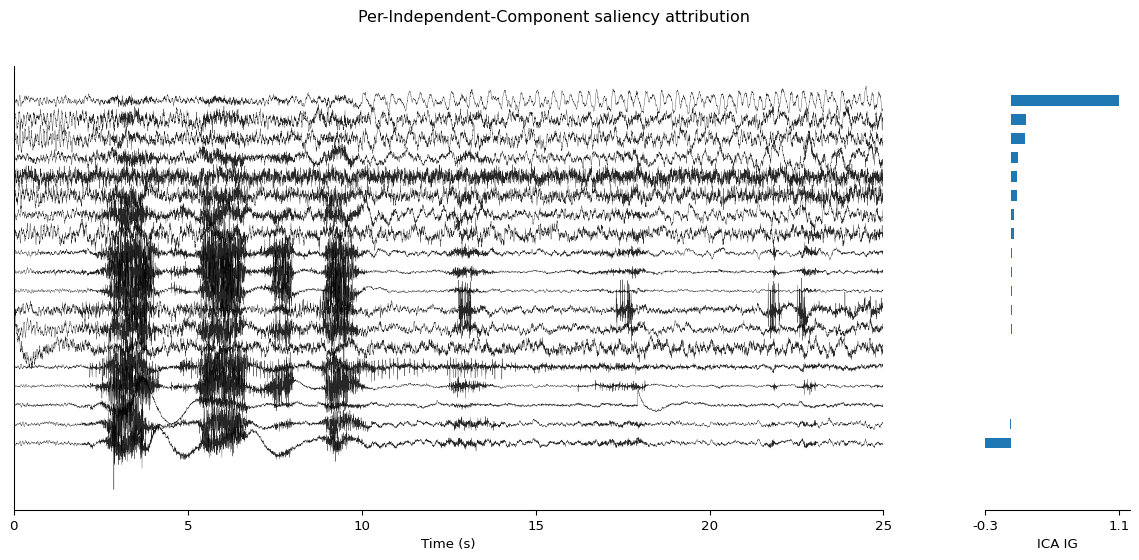

In [ ]:
plot_multichannel_with_importance(X_ica.T, ig_ica, channels, window_size_sec, (15, 6))
plt.suptitle('Per-Independent-Component saliency attribution')

**Left.** Time plot of all 19 Independent Components decomposed by FastICA. Components are plotted from the most to the least important according to the ICA-domain saliency map we generated. The first channel contains the majority of oscillations associated with seizure electrical activity. The last channels contain interference.\
**Right.** Importance score for each component.

**Saliency map interpretation.** ICA-IG attributes a score of importance to each indipendent component (IC). Since we can intuitively assign a meaningful interpretation to each of these ICs (seizure activity, interference, noise, etc.), each individual value of the saliency maps carries an inherent semantic interpretation.

The IC with the highest importance is also the one which we would identify as the most relevant with clear oscillations which start around 10-12 seconds. This reassures that the model is correctly inferring seizure - not relying in any irrelevant electrical activities.

The next question is: The model is focusing on seizure-relevant activity, but which oscillations are the ones that are affecting the most its output?

## ICA-Frequency-domain saliency maps

Cross-domain IG allows for stacking multiple transforms consecutively. This allows us to examine which EEG wavebands of the isolated seizure component contribute the most to the model's output.

To do so we construct a composite transform:
1. An ICA transform decomposes the original input to its independent components.
2. A fourier transform

We extend the library's FourierDomain to include the first ICA transform step before transforming into frequency domain.

In [ ]:
from cross_domain_saliency_maps.torch_ig.domain_transforms import DomainBase

class ICAFourierDomain(DomainBase):
  def __init__(self, ica, device, dtype = torch.float32, time_dimension = -1):
    super().__init__(dtype = dtype, device = device)
    self.ica = ica
    self.time_dimension = time_dimension

  def forward_transform(self, x):
    """ Transforms an input into the ICA -> Fourier domain.

    Args:
        x (np.array): The input to transform.

    Returns:
        torch.Tensor: The transformed input.
    """
    x_ica = self.ica.transform(x[0, ...].T).T
    x_ica = torch.from_numpy(x_ica).type(self.dtype).to(self.device)
    return torch.fft.fft(x_ica, dim = self.time_dimension)

  def set_coefficients(self, x: np.array, x_baseline: np.array):
    """ Sets the frequency coefficients transforming the input and
    baseline samples into the ICA and then the frequency domain.

    Args:
        x (np.array): The input sample in time-domain.
        x_baseline (np.array): The baseline sample in time-domain.
    """
    self.mixing_matrix = torch.from_numpy(self.ica.mixing_).type(self.dtype).to(self.device)
    self.mean = torch.from_numpy(self.ica.mean_[..., None]).type(self.dtype).to(self.device)

    self.coefficients = self.forward_transform(x)
    self.baseline_coefficients = self.forward_transform(x_baseline)


  def inverse_transform(self, x_input: torch.Tensor):
    """ Inverse transform, transforming the frequency domain input
    x_input points back into the ICA domain and then back to the
    original input.

    Args:
        x_input (torch.Tensor): The frequency domain input.
    """
    x_time = torch.fft.ifft(x_input, dim = self.time_dimension)
    x_time = x_time.type(self.dtype)
    x_time = torch.matmul(self.mixing_matrix, x_time) + self.mean
    return x_time[None, ...]

We can now define ICAFourierIG, similarly to how ICAIG is defined. After ICAFourierIG estimates the saliency map in the Fourier-ICA domain, it aggergates the contribution of each individual frequency bin into the ```frequency_bands``` providing saliency at the EEG-band lavel:
- Delta: $0.5 - 4 Hz$
- Theta: $4 - 8 Hz$
- Alpha: $8 - 12 Hz$
- Beta: $12 - 30 Hz$
- Gamma: $30 - 100 Hz$

The final ```ICAFourierIG``` output provides an importance score for each of the 5 wavebands for each component isolated by ICA.

In [ ]:
from cross_domain_saliency_maps.torch_ig.cross_domain_integrated_gradients import CrossDomainIG

class ICAFourierIG(CrossDomainIG):
  """ Implementation of the CrossDomainIG specifically for the
  ica-fourier target domain.
  """
  def __init__(self,
                model: torch.nn.Module,
                ica: FastICA,
                n_iterations: int,
                fs : float,
                output_channel: int,
                device: torch.device,
                dtype = torch.float32):
    super().__init__(model, n_iterations,
                      output_channel, dtype)

    self.initialize_domain(ICAFourierDomain, device = device, ica = ica, dtype = dtype)
    self.fs = fs

    self.frequency_bands = { #Hz
        'delta' : [0.5, 4],
        'theta' : [4, 8],
        'alpha' : [8, 12],
        'beta' : [12, 30],
        'gamma' : [30, 100]
    }

  def freqIG2Bands(self, channelFourierIG, fs, aggregation = 'sum'):
    N = channelFourierIG.shape[0]
    T = 1/self.fs
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

    band_ig = []
    for key in self.frequency_bands.keys():
        band_limits = self.frequency_bands[key]
        index_from = np.argwhere(xf >= band_limits[0]).flatten()[0]
        index_to = np.argwhere(xf < band_limits[1]).flatten()[-1]

        if aggregation == 'sum':
            band_ig.append(channelFourierIG[index_from : index_to].sum(axis = 0))
        else:
            band_ig.append(channelFourierIG[index_from : index_to].mean(axis = 0))

    band_ig = np.stack(band_ig, 0)

    return band_ig

  def run(self, x: np.array, x_baseline: np.array):
    """ Runs the IG generation. We aggregate frequency bins into wavebands.

    Args:
        x (np.array): Input sample for which to generate saliency.
        x_baseline (np.array): Baseline sample.
    """
    super().run(x, x_baseline)
    self.multiIG = self.multiIG.cpu().numpy()
    band_ig = self.freqIG2Bands(self.multiIG.T, self.fs)
    self.multiIG = band_ig
    return self.multiIG

In [ ]:
icaFourierIG = ICAFourierIG(model_wrapped, fastICA, n_ig_iterations,
                            fs = fs,
                            output_channel = 1, device = device)
ig_ica_fourier = icaFourierIG.run(x, x_baseline)

  0%|          | 0/300 [00:00<?, ?it/s]/tmp/ipython-input-385805727.py:46: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /pytorch/aten/src/ATen/native/Copy.cpp:307.)
  x_time = x_time.type(self.dtype)
100%|██████████| 300/300 [00:05<00:00, 55.73it/s]


In [ ]:
sorted_channel_indices = np.argsort(ig_ica)[::-1]
seizure_sorted_channel_indices = sorted_channel_indices[ig_ica[sorted_channel_indices] > 0]

Let's define a helper plot function to better visualise our saliency map.

In [ ]:
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import mne
import scipy

def bandDecomposition(component, band_importance, frequency_bands, fs, numtaps = 51):
  output_signal = 0

  for key in frequency_bands.keys():
      b = scipy.signal.firwin(numtaps, [frequency_bands[key][0], frequency_bands[key][1]],
                              pass_zero = 'bandpass', fs = fs)
      y = scipy.signal.filtfilt(b, 1, component) * band_importance
      output_signal += y

  return output_signal

def isolateICComponent(eeg_signal, ica, componentIndex, fs, filterBands = True,
                       bandIGs = None, frequency_bands = None):
  X_ica = ica.transform(eeg_signal.T)

  componentOfInterest = X_ica[:, componentIndex]

  band_importance = np.max(bandIGs, 0)
  band_importance = (band_importance - band_importance.min()) / (band_importance.max() - band_importance.min())
  band_importance = band_importance[..., componentIndex]

  if filterBands == True:
    componentOfInterest = bandDecomposition(componentOfInterest,
                                            band_importance,
                                            frequency_bands,
                                            fs, numtaps = 51)

  isolatedICA = np.zeros_like(X_ica)
  isolatedICA[:, componentIndex] = componentOfInterest

  isolatedComponent = ica.inverse_transform(isolatedICA)

  return isolatedComponent

eeg_signal = x[0]
def plot_frequency_ig_plots(eeg_signal, icaFourierIG, window_size_sec, channels,
                            X_ica, components_to_plot = 1, offset = 4000,
                            scale = 30.0):
  n_timepoints = x.shape[-1]
  time = np.linspace(0, window_size_sec, n_timepoints)


  info = mne.create_info(ch_names = channels, sfreq = 250, ch_types=['eeg'] * 19)
  template = mne.channels.make_standard_montage(
    kind='standard_1020',
    head_size=0.095
  )

  # 3. Now pick out only the 19 you care about
  pos = template.get_positions()['ch_pos']
  ch_pos_19 = {ch: pos[ch] for ch in channels}

  # 4. Build a new montage and plot it
  montage_19 = mne.channels.make_dig_montage(
      ch_pos=ch_pos_19,
      nasion=template.get_positions()['nasion'],
      lpa=template.get_positions()['lpa'],
      rpa=template.get_positions()['rpa'],
      coord_frame='head'
  )

  info.set_montage(montage_19, match_case=False)

  frequency_bands = icaFourierIG.frequency_bands

  X_input = torch.from_numpy(X_ica).type(torch.float32)[None, ...]
  X_input = torch.fft.fft(X_input, dim = 1).numpy()[0]
  X_input_bands = icaFourierIG.freqIG2Bands(np.abs(X_input), fs, aggregation = 'mean')

  n_comp = ig_ica_fourier.shape[1]
  max_ig = np.max(np.abs(ig_ica_fourier))

  patterns = fastICA.mixing_.T

  fig_width = 12
  row_height = 6  # inches per IC row (including title and plots)
  title_ratio = 0.1  # relative fraction of row height for title vs plots
  # For horizontal columns in plot area: relative widths
  left_width_ratio = 0.5  # left column width ratio (for topomap+band)
  time_width_ratio = 2.0  # right column width ratio (for time plot)
  # Within left column: fraction of plot area height for band plot
  band_height_fraction = 0.3  # fraction of left plot-area height for band plot; topomap gets remaining
  gap_fraction = 0.05       # fraction of row width used as gap between columns

  user_band_ymin = None
  user_band_ymax = None

  n_comp = components_to_plot
  total_height = n_comp * row_height
  fig = plt.figure(figsize=(fig_width, total_height))

  outer_hspace = 0.1
  outer_gs = GridSpec(n_comp, 1, figure=fig, hspace=outer_hspace)

  for idx in range(components_to_plot):
    row_spec = outer_gs[idx, 0]
    bbox = row_spec.get_position(fig)
    x0, y0 = bbox.x0, bbox.y0
    row_w, row_h = bbox.width, bbox.height


    total_ratio = title_ratio + 1.0
    title_h = row_h * (title_ratio / total_ratio)
    plot_h = row_h - title_h

    # Title axis
    ax_title = fig.add_axes([x0, y0 + plot_h, row_w, title_h])
    ax_title.text(0.5, 0.5, f'IC {idx}', ha='center', va='center', fontsize=12)
    ax_title.axis('off')

    plot_x0 = x0
    plot_y0 = y0

    gap = row_w * gap_fraction
    total_w_ratio = left_width_ratio + time_width_ratio
    avail_w = row_w - gap
    w_left = avail_w * (left_width_ratio / total_w_ratio)
    w_time = avail_w * (time_width_ratio / total_w_ratio)
    x_left = plot_x0
    x_time = plot_x0 + w_left + gap

    band_h = plot_h * band_height_fraction
    topo_h = plot_h - band_h

    y_band = plot_y0
    y_topo = plot_y0 + band_h


    ax_topo = fig.add_axes([x_left, y_topo, w_left, topo_h])

    mne.viz.plot_topomap(patterns[sorted_channel_indices[idx]], info,
                          axes=ax_topo, show=False)
    ax_topo.axis('off')


    ax_band = fig.add_axes([x_left, y_band, w_left, band_h])
    data = ig_ica_fourier[:, sorted_channel_indices[idx]]
    ax_band.plot(data, '-o', color='C1')
    freq_scale = data.max() / X_input_bands[..., sorted_channel_indices[idx]].max()
    ax_band.plot(X_input_bands[..., sorted_channel_indices[idx]] * freq_scale, color = 'black')
    ax_band.hlines(0.0, 0.0, 5.0, linestyles = 'dashed', color = 'r')
    ax_band.set_ylim([-max_ig * 0.1, max_ig * 1.1])

    y_min_plot = -max_ig * 0.1
    y_max_plot = max_ig * 1.1

    ax_band.yaxis.set_major_locator(ticker.FixedLocator([y_min_plot, y_max_plot]))
    ax_band.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    n_inter = 5
    minor_loc = np.linspace(y_min_plot, y_max_plot, n_inter)
    ax_band.yaxis.set_minor_locator(ticker.FixedLocator(minor_loc))

    ax_band.set_axisbelow(True)
    ax_band.grid(which='minor', alpha=0.2)


    ax_band.set_xticks(np.arange(len(frequency_bands)))
    ax_band.set_xticklabels(list(frequency_bands.keys()), rotation=45, fontsize=8)

    ax_band.tick_params(axis='y', pad=5)

    ax_band.set_axisbelow(True)
    ax_band.grid(which='major', alpha=0.2)
    ax_band.spines['top'].set_visible(False);
    ax_band.spines['right'].set_visible(False)
    ax_band.spines['left'].set_visible(True);
    ax_band.spines['bottom'].set_visible(True)

    ax_time = fig.add_axes([x_time, plot_y0, w_time, plot_h])
    isolatedComponent = isolateICComponent(eeg_signal, fastICA, filterBands = True,
                                            componentIndex = sorted_channel_indices[idx], fs = fs,
                                            bandIGs = ig_ica_fourier, frequency_bands = frequency_bands)

    component_scale = (offset / isolatedComponent.std())/10

    for i in range(19):
        ax_time.plot(time, scale * eeg_signal[i, ...] + i * offset,
                  color='black', linewidth = 0.25,
                  alpha = 0.85)

        ax_time.plot(time, component_scale * isolatedComponent[..., i] + i * offset,
                    color = 'C1', linewidth = 0.5)


        ax_time.set_xlim([time[0], time[-1]])
        ax_time.spines[['top', 'right']].set_visible(False)

    ax_time.set_yticks(list(range(1, 19 * offset, offset)), channels)
    ax_time.set_xlabel('Time (s)')

    ax_time.set_xlabel('Time')
    ax_time.grid(True, alpha=0.2)

Finally, we plot the results.

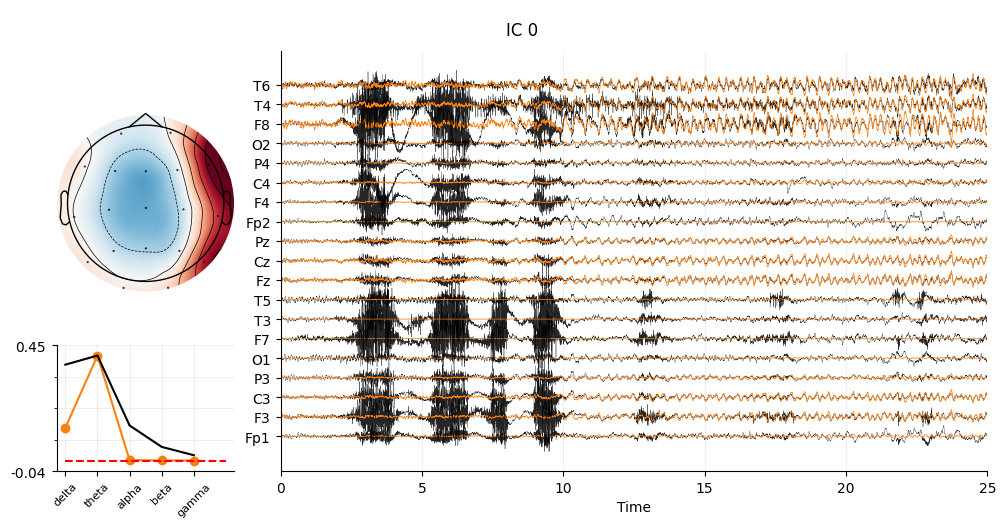

In [ ]:
plot_frequency_ig_plots(eeg_signal, icaFourierIG, window_size_sec, channels,
                            X_ica, components_to_plot = 1, offset = 4000,
                            scale = 30.0)

**Left top.** Topomap of the most important Independent Component. \
**Left bottom.** Bandwave-level saliency map for this Independent component. The input's spectral information are presented in black, while the saliency map in orange. Zero importance is represented with the dashed red line.\
**Right.** Plot of all 19 raw channels in the time domain. The original raw input is presented in black. We filter the input retaining only the most important IC and frequency bands. The filtered signal is presented in orange.

**Saliency map interpretation.** ICA-Fourier IG identifies the EEG wavebands of the seizure component which most affect the model's output. Although the signal carries information throughout all delta-gamma bands, the model focuses mostly on theta waves, and partially on delta oscillations.

Since we have also identified the most important ICs and wavebands, we can provide a filetered version of the input signal according to what the model *believes* is the most important information for seizure detection. In the filtered signal the interference has been successfully removed, and only seizure-related information remains.